<a href="https://colab.research.google.com/github/lutzeric/text_mining_sinopsis/blob/main/intertexualidad_bafici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de la intertextualidad de películas del Buenos Aires Festival Internacional de Cine Independiente (BAFICI)**

El BAFICI es un festival de cine que se celebra desde 1999 en la Ciudad de Buenos Aires donde se muestra cine independiente de diversos géneros, países y temáticas. Desde la edición 2008, la programación está disponible para consultar en internet. Esta información consta de una ficha técnica de cada película, es decir, cuenta quiénes trabajaron en la dirección, producción, guion, fotografía, sonido, etc, junto con el título, duración, año, países donde se produjo, formato y color. Además, casi todas las películas cuentan con una **sinopsis**, una descripción escrita por una persona especializada que busca ayudar a tener una idea de la película antes de verla. No necesariamente es una crítica y no tiene ningún tipo de puntuación, sino que son más bien descriptivas de la trama, la dirección u otro aspecto que le haya parecido interesante a la persona que la escribió. Cada película tiene una única sinopsis (o, en raros casos, ninguna) y el estilo de escritura varía bastante entre las personas que la escriben. Por ello, es común ver sinopsis que hablan mucho sobre otras películas, personajes o directorxs (intertextualidad), mientras que otras son más cerradas en sí mismas, sin una conexión explícita con otras películas. Además, algunas sinopsis cuentan con la firma de la persona que la escribió (o la cita de la fuente como puede ser un diario), mientras que otras no.
Al menos desde el 2010, cada edición consta de entre 300 y 450 películas. También desde ese año, cada película cuenta con una página web propia, donde están su ficha y su sinopsis. 

Este trabajo busca hacer un análisis de las sinopsis en cuanto a cómo se conectan las unas a las otras, cómo se pueden agrupar, y cuánto nos hablan (explícita o implícitamente) de quiénes la dirigieron, los países donde se rodó, el año o su duración.

En este notebook se muestra el proceso desde la extracción de los datos mediante scrapeo de páginas web, hasta la visualización de la conexión entre las sinopsis mediante un grafo.

# 1) Extracción de los datos

Desde el 2010, cada edición del BAFICI cuenta con su propia página web principal. Dentro de esta, cada película cuenta también con su propia página, con un diseño (casi) idéntico entre ellas. De la edición 2010 a 2013 la descarga de datos se puede automatizar bastante fácilmente, con ligeras variaciones entre las ediciones. Si no, en la página del Gobierno de la Ciudad están los .csv disponibles. Sin embargo, desde 2014 el código cambia rotundamente y es bastante más engorrosa la automatización, y los datos en bloque no están disponibles al público, salvo en pdfs complicados de leer con Python. Por cuestiones de tiempo, obtuve únicamente los datos de las ediciones 2010 a 2013, totalizando información de cerca de 1600 películas, que para este trabajo es un muy buen número para comenzar.

La información de estas ediciones se puede encontrar en https://festivalesanteriores.buenosaires.gob.ar/bafici/home13/web/es/bafici/pasteditions.html

A continuación, voy a mostrar el proceso solo para la edición 2013, siendo muy similar al utilizado para las ediciones anteriores.

Lo primero que hice fue crear una carpeta en mi Google Drive donde voy a guardar la información de cada edición (en este caso, 2013). Luego, monté mi drive y cargué la dirección de la carpeta.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
carpeta = '/content/gdrive/MyDrive/Doctorado/bafici/2013/'

Para el scrapeo voy a utilizar las bibliotecas:

1.   requests: para obtener la información cruda de la página
2.   time: para dejar pasar tiempo entre requests y que no me bloqueen la IP
3.   bs4, y de ahí BeautifulSoup para leer el código HTML





In [ ]:
# Importo las bibliotecas que voy a utilizar
import requests
import time
from bs4 import BeautifulSoup as BS 

Ahora hay que especificarle la página de donde el programa va a sacar cada película. Afortunadamente, la dirección es la misma salvo por un número de índice que identifica a cada película. En esta edición, los índices van del 1 al 420 aprox. Como hay índices que no contienen películas o páginas que pueden tener algún error, le voy a pedir al programa que intente obtener la información y si no, que siga sin detenerse por errores.

Las variables que me interesan por ahora son el número de índice (meramente para identificación rápida) el título, la dirección, la duración, los países y la sinopsis de cada película. Para cada película el programa arma una lista (*lis*) donde cada elemento es un string con el nombre y el contenido de la variable (ej: 'Duración: 45'), y finalmente guarda todas las listas en una lista única (*pelis*). Si para un campo no hay información disponible, el programa escribe 'NN' para esa variable.

Entre películas deja 2 segundos de pausa.

In [ ]:
url = "https://festivalesanteriores.buenosaires.gob.ar/bafici/home13/web/es/films/show/v/id/"

pelis = []

for n in range (1, 420, 1): #1:420
    try:

        # Hacemos request al url actual
        response = requests.get(url + str(n) + '.html')

        # Creamos la sopa
        soup = BS(response.content)

        # Identificamos los elementos y los sumamos a sus respectivas listas
        elements = soup.find_all(attrs={'class':'data'})
        estring = str(elements[0].text)
        lis = []
        sep = estring.split('\n')
        ti = sep.index('Título de Exhibición')
        titulo = 'Título: ' + sep[ti+1]

        if 'Director' in sep:
            di = sep.index('Director')
        elif 'Directores' in sep:
            di = sep.index('Directores')
        directores = 'Directores: ' + sep[di+1]

        an = sep.index('Año')
        anio = 'Año: ' + sep[an+1]

        du = sep.index('Duración')
        duracion = 'Duración: ' + sep[du+2][:-8]

        num = 'Número: ' + str(n)

        #paises
        elements = soup.find_all(attrs={'id':'textarea'})
        estring2 = str(elements).split('\n')
        if '<th>País</th>' in estring2:
            pa = estring2.index('<th>País</th>')
        elif '<th>Países</th>' in estring2:
            pa = estring2.index('<th>Países</th>')
        seq = estring2[pa+1].split('title=')
        paises= 'Países: '
        for p in seq[1:]:
            a = p.split('"/></a>\xa0<')
            if len(seq[1:])>1:
                paises += ', ' + a[0][1:]
            else:
                paises += a[0][1:]

        #sinopsis
        if '<p>' in estring2:
            si = estring2.index('<p>')
            es = estring2[si+1]
            es2 = es.split('</p><p>')
            sinopsis = 'Sinopsis: ' + es2[1][:-4]
        
        lis = [num, anio, titulo, paises, directores, duracion, sinopsis]
        pelis.append(lis)
        time.sleep(2)
    except:
        pass

Finalmente, el programa abre y guarda un bloc de notas donde escribe, película por película, su número, título, año, países, directorxs, duración y sinopsis. Este bloc de notas luego lo limpié a mano para sacarle algunos errores pequeños, pero difíciles de automatizar, como que el nombre de los países (cuando es más de uno) no tenía comas separándolos. El resultado final será un .txt por cada edición del BAFICI, que luego será usado en la siguiente fase.

In [ ]:
texto_completo = ''
for i in pelis: #voy peli por peli
    num = i[0]
    anio = i[1]
    titulo = i[2]
    paises = i[3]
    directores = i[4]
    duracion = i[5]
    sinopsis = i[6]
    texto = num + '\n' + titulo + '\n' + anio + '\n' + paises + '\n' + directores + '\n' + duracion + '\n' + sinopsis + '\n' + '\n' 
    texto_completo += texto
with open(carpeta + 'bafici_13_todas' + ".txt", "w") as f:
    f.write(texto_completo)

# 2) Procesamiento de la información de cada película.
Partiendo de los .txt de cada edición, se junta toda la información, se la limpia, se la vectoriza, se hacen clusters y se deja todo listo para hacer el grafo final.

Primeramente, monto mi drive si hace falta, y escribo la dirección de la carpeta donde están los .txt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
carpeta = '/content/gdrive/MyDrive/Doctorado/bafici/'

Mounted at /content/gdrive


Armo una lista para cada una de las variables de mi interés: título, directorxs, duración, año, países, edición del BAFICI y sinopsis de cada película encontrada. Luego voy recorriendo cada archivo de texto y voy agregando cada item a la lista correspondiente. El resultado final es una lista con todos los títulos, todxs lxs directorxs, sinopsis, etc. de todas las películas extraídas.

In [ ]:
titulo = []
directores = []
duracion = []
anio = []
sinopsis = []
paises = []
edicion = []

for i in range(10,14):
    with open(carpeta + str(i) +'.txt', "r") as file: # abrimos el .txt
        lineas = file.readlines()
        for l in lineas:
            if l.startswith('Sinopsis'):
                sin = l.replace('\n', '')
                sinopsis.append(sin[10:].strip())  
                edicion.append(int('20' + str(i)))
            elif l.startswith('Título:'):
                tit = l.replace('\n', '')
                titulo.append(tit[8:].strip())
            elif l.startswith('Directores:'):
                dir = l.replace('\n', '')
                dir = dir.replace('&', ',')
                directores.append(dir[11:].strip())
            elif l.startswith('Año'):
                an = l.replace('\n', '')
                try:
                    anio.append(int(an[4:]))
                except:
                    anio.append(an[4:])
            elif l.startswith('Duración:'):
                dur = l.replace('\n', '')
                try:
                    duracion.append(int(dur[10:]))
                except:
                    duracion.append(dur[10:])
            elif l.startswith('Países:'):
                pai = l.replace('\n', '')
                paises.append(pai[8:].strip())  

Empiezo la limpieza armando una lista (*autorx*) los nombres de la gente que firmó las sinopsis o referencias a diarios donde aparecieron originalmente. Como no todas las sinopsis tienen firmas o citas, preferí buscar a mano los nombres para evitar perder información de más.

In [ ]:
autorx = ['Javier Porta Fouz', 'Fran Gayo', 'Violeta Bava', 'Marcelo Panozzo', 
          'Clarín', 'Nación', '9/4/1982', 'Opinión', 'Convicción', 
          'Ámbito Financiero', 'Amigo Americano', '5/10/1978', '21/2/1980',
          'Oscar Jalil', 'Nº 1, 1980', '31/7/1981', '9/4/1992', '24/8/1995',
          '17/4/1997', '12/9/2002', 'Página/12', 'Paula Félix-Didier', 
          'Eduardo Pla', 'Hans Hurch', 'Joan Pons', 'Marcelo Pavazza', 'Christoph Huber',
          'Miguel Calero', 'Agustín Masaeo', 'Chelsey Grasso', 'Birgit Flos',
          'Tiziana Panizza', 'Juan Manuel Domínguez', 'Leandro Listorti', 'Luciano Monteagudo',
          'Peter Travers', 'Pablo Marín', 'Quintín', 'Anna Bielak', 'Erez Pery', 'Mariano Kairuz',
          'Jaime Pena', 'Marcela Gamberini', 'Mark Peranson', 'Raúl Camargo', 
          'Alejandro Díaz Castaño', 'Marcelo Alderete', 'Roger Koza', 'Jonathan Rosenbaum',
          'Paolo Bertolin', 'Gustavo Noriega', 'Diego Lerer', 'Florencia Grieco', 'Aaron Hillis',
          'IDFA', 'Jean-Michel Frodon', 'Astra Taylor', 'Andrés Levinson', 
          'Violeta Kovacsics', 'Frank Scheffer', 'Javier Diz', 'Leandro Godón',
          'Scott Foundas', 'Victoria Ceccott', 'Nando Salvá', 'Edwin Carels',
          'Gabe Klinger', 'Liu Jiayin', 'Jean-Pierre Rehm', 'Victoria Ceccotti',
          'Alejandro G.Calvo', 'Nando Salvá', 'Guido Segal', 'DOC Buenos Aires',
          'César Maranghello', 'Manuel Yáñez Murillo', 'Giada Colagrande']

El programa recorre una a una las sinopsis y se fija si coincide parte de su texto con las cadenas en la lista *autorx*. En caso de coincidir, se elimina esa firma y se guarda el texto limpio de autorxs y citas. En caso de no coincidir, se guarda el texto de la sinopsis tal cual estaba. La lista donde se guardan se llama *limpia_autorx*.

In [ ]:
limpia_autorx = []  #lista con todas las sinopsis sin autorxs ni citas

for s in sinopsis:
    for a in autorx:
        if a in s:
            s = s.replace(a, '')    #si está firmada, borrar la firma
            break                   #solo hay una firma/cita por sinopsis
    limpia_autorx.append(s)

#para probar si funcionó: veo la sinopsis 1330, firmada por Fran Gayo
# sinopsis[1330]
# limpia_autorx[1330]

Ahora a las sinopsis sin firmas les saco stopwords del español, que están cargadas en un .txt que encontré en un repositorio, y otras palabras de uso frecuente que no son identificatorias de ninguna película en sí. Por ejemplo: "película", "protagonista". Guardo las sinopsis limpias de firmas y de palabras indeseadas en *limpia_sw*.

In [ ]:
#armo una lista de palabras de uso frecuente y stop words
sw = ['película', 'películas', 'festival', 'bafici', 'cine', 'competencia', 
      'directores', 'director', 'directora', 'directoras', 'dirigió', 'dirigida', 'film', 'films', 'producida',
      'edición', 'cineasta', 'foco', 'protagonista', 'historia', 'forma', 'personaje', 'cámara', 'comenzó',
      'montaje', 'incluir', 'cuyo', 'cuya', 'produjo', 'productora', 'productor', 'obra',
      'relato', 'cinematográfico', 'contar', 'allí', 'escena', 'personajes', 'irá']

#a esa lista le sumo una de stopwords de Español
with open(carpeta + 'spanish.txt', "r") as file: # abrimos el .txt
        lineas = file.readlines()
        for l in lineas:
            sw.append(l[:-1])

#armo una lista nueva para las sinopsis limpias
limpia_sw = []
for s in limpia_autorx:
    palabras = s.split(' ')
    limpia1 = ''
    for p in palabras:
        p = p.replace(',','')
        p = p.replace('”','')
        p = p.replace('“','')
        p = p.replace('(','')
        p = p.replace(')','')
        p = p.replace('!','')
        p = p.replace('?','')
        p = p.replace('¿','')
        p = p.replace('¡','')
        p = p.replace(':','')
        p = p.replace(';','')
        p = p.replace('-','')
        p = p.replace('\-','')
        p = p.replace('\<','')
        p = p.replace('\>','')
        p = p.replace('>','')  
        p = p.replace('<','')          
        p = p.replace('  ','')
        p = p.replace('\.','')
        p = p.replace('.','')
        p = p.replace('º','')
        if p.lower() not in sw: #coloco solo las palabras que no son sw
            limpia1 += ' ' + p
    limpia_sw.append(limpia1)

#Prueba
# limpia_autorx[1330]
# limpia_sw[1330]


Con las sinopsis limpias, armo un dataframe de pandas incluyendo título, directorxs, año, países, duración, edición del BAFICI y sinopsis para cada película.

In [ ]:
# Importo pandas para el dataframe
import pandas as pd

In [ ]:
df = pd.DataFrame(list(zip(titulo, directores, anio, paises, duracion, edicion, limpia_sw)),
               columns =['Titulo', 'Directores', 'Anio', 'Paises', 'Duracion', 'Edicion', 'Sinopsis'])

Aquí hago una limpieza más, esta vez de películas con algún campo vacío o con sinopsis de menos de 250 caracteres.

In [ ]:
df.drop_duplicates(subset=['Sinopsis'], inplace=True)
df.drop_duplicates(subset=['Titulo', 'Duracion', 'Anio'], inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.replace(" ", nan_value, inplace=True)
df.replace("NN", nan_value, inplace=True)
df.replace(" NN", nan_value, inplace=True)
df.replace("Varios", "VARIOS DIRECTORXS", inplace=True)
df.dropna(inplace=True)

df['length'] = df.Sinopsis.str.len()
df.drop(df[df['length'] < 250].index, inplace = True)
df = df.drop(columns='length')

df

# Clustering

Me quedo con los datos de 1289 películas. Ahora hago la vectorización de las sinopsis con sklearn TfidfVectorizer incluyendo bigramas y trigramas, y descartando palabras que aparecen en el 80% de las sinopsis. Con CountVectorizer quedan muchos clusters con una sola sinopsis y uno con casi todas.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer #probar con CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.7)    #agregar bigramas o trigramas, descartar features poco frecuentes, max_df, min_df
data = vectorizer.fit_transform(df['Sinopsis'])

Ahora utilizo Kmeans y calculo la suma de distancias al cuadrado para 2 a 19 clusters. El número "óptimo" de clusters podría verse mediante el método del codo (gráfico). Este es un acercamiento meramente cualitativo

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,20) #me fijo entre 2 y 19 clusters 
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(data)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

No parece haber un cambio notorio en la curva. Siendo un número práctico, me quedo con seis clusters.

In [ ]:
true_k = 6

Ahora hago la clusterización y armo un nuevo dataframe (*df_cl*) que es como el anterior, pero con una columna con el número de cluster

In [ ]:
d_directores = df['Directores']
d_paises = df['Paises']
d_edicion = df['Edicion']
d_anio = df['Anio']
d_titulo = df['Titulo']
d_sinopsis = df['Sinopsis']

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(data)
labels=model.labels_
df_cl=pd.DataFrame(list(zip(d_titulo, d_directores,d_paises, d_edicion, d_anio, d_sinopsis, labels)),
                     columns=['Titulo', 'Directores', 'Paises', 'Edicion', 'Año', 'Sinopsis', 'cluster'])

Un poco de información sobre cada cluster. Se ve que los clusters son dentro de todo homogéneos en cuanto a la cantidad de películas. El 1 nomás es bastante más desparejo que el resto.

In [ ]:
#cantidad de películas por cluster
df_cl.groupby('cluster')['Directores'].count() 

cluster
0    147
1    272
2    197
3    245
4    204
5    224
Name: Directores, dtype: int64

Sería interesante ver si unx mismx directorx o dupla/tripla de directorxs están dentro del mismo cluster o si están diseminados en varios. Para eso, tomo del dataframe solo aquellos que están repetidos y borro los que dicen 'Varios', ya que se pueden estar refiriendo a distintas tuplas de directorxs.

Este mismo procedimiento puede repetirse para otra variable de interés como países o duración.

In [ ]:
dirs_rep = df_cl[df_cl.Directores.duplicated(keep=False)]
dirs_rep = dirs_rep[dirs_rep.Directores != 'Varios']
dirs_rep

Quedan 406 valores de directorxs que aparecen más de una vez. Una manera fea, pero rápida de ver si todas las películas de unx mismx (o tupla de) directorx/s se agrupan en el mismo cluster es realizar un boxplot. Sé que hay métodos que analizan la pureza de cada cluster, pero no los sé usar y por cuestión de tiempo prefiero seguir avanzando.

In [ ]:
#bibliotecas para graficar y guardar las figuras
import seaborn as sns
from google.colab import files

In [ ]:
fig, ax = plt.subplots(figsize=(14.7, 8.27))
d_plot = sns.boxplot(ax=ax, x='Directores', y='cluster', data=dirs_rep)
d_plot.set(xticklabels=[])

plt.savefig("box_directores.png")
files.download("box_directores.png") 

Se ve que la gran gran mayoría de lxs directorxs están dispersos en diferentes clusters. Por ahora quiénes son los que están en un único cluster no es algo que me interese como para detenerme.
A continuación repito el procedimiento anterior, pero con países/tuplas de países.

In [ ]:
#me quedo con los países que aparecen más de una vez
paises_rep = df_cl[df_cl.Paises.duplicated(keep=False)]
paises_rep

In [ ]:
fig, ax = plt.subplots(figsize=(14.7, 8.27))
d_plot = sns.boxplot(ax=ax, x='Paises', y='cluster', data=paises_rep)
d_plot.set(xticklabels=[])

plt.savefig("box_paises.png")
files.download("box_paises.png") 

Como sucedió con lxs directorxs, la gran mayoría de los países están representados en varios clusters. Por ahora no me importa cuál es cuál, así que no le puse los nombres al eje X.

Ahora lo que se puede hacer es para cada cluster ilustrar las palabras de las sinopsis que más lo representan usando nube de palabras de wordcloud.

In [ ]:
from wordcloud import WordCloud
result={'cluster':labels,'Sinopsis':df['Sinopsis']}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['Sinopsis'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Directores')
   dires=df_cl[df_cl.cluster==k]['Directores']
   print(dires.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()
   #imprimir número de películas por cluster

A simple vista no veo palabras que distingan fuertemente entre clusters. Lo que sí veo es que palabras como 'documental' y 'obra' están en todos o casi todos los clusters. Podría volver a correrse sin tener en cuenta estas palabras, aunque preferí dejar 'documental' ya que hay muchas documentales, pero también muchas ficciones y quizás se distinguían por eso en un cluster único.

En una de las versiones anteriores del programa me habían quedado clusters con una única película, cuyas sinopsis tenían palabras que no eran del castellano, muy probablemente nombres de personas o lugares de Alemania, Países Bajos, Polonia, etcétera, o bien de Japón. Lo que debe haber pasado es que esas palabras raras eran tan distintivas que "tironeaban" bastante y evitaban que esas sinopsis se juntaran con otras.

# Grafos

Instalo las bibliotecas que voy a usar para armar los grafos y visualizarlos

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph

Esta función genera un grafo dirigido o digrafo (*nx.DiGraph*) a partir de los nodos y sus aristas. Dentro de ella está la función *get_relations*, explicada más abajo. En ella se listan los pares de películas cuya sinopsis presenta intertextualidad. Para una visualización del grafo más sencilla, decidí no tener en cuenta aquellas películas que no están relacionadas explícitamente a otras.


In [ ]:
def build_graph(titulos, directores, sinopsis):
    '''listas de títulos, de directores y de sinopsis''' 

    # get weighted edges
    edges = get_relations(titulos, directores, sinopsis)
    
    unicas = []
    for i in edges:
        for k in i:
            unicas.append(k)
    s = set(unicas)

    # get graph nodes
    nodes = list(s)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

*get_relations* toma una lista de títulos, de directorxs y de sinopsis y recorre todas las sinopsis una por una, fijándose si nombran el título o directorxs de otra película de la lista. Si es así, guarda el par (película sinopsis - película nombrada) en la lista *relacionadas*. Notar que esta relación está dirigida únicamente desde la primera película a la segunda. En caso de que la segunda película nombre a la primera, se guardará como un par distinto. En caso de repetición de un mismo par, solo se tiene en cuenta la primera instancia.

In [ ]:
def get_relations(titulos, directores, sinopsis):
    #las relaciones son palabras en común entre las sinopsis
    relacionadas = []
    i = 0
    while i < len(titulos):
        j = 0
        while j < len(sinopsis):
            if i != j:
                if len(titulos[i])>6:
                    if (titulos[i] in sinopsis[j]) or (directores[i] in sinopsis[j]):
                        par = [titulos[j], titulos[i]]
                        if par not in relacionadas:
                            relacionadas.append(par)
            j += 1
        i += 1
        
    return relacionadas

Esta última función se encarga de graficar un grafo con un tamaño,título y colores de nodos personalizables. También en esta función se le puede asignar un peso a cada relación, en caso de que deseáramos distinguir cuándo una dupla aparece más de una vez.
Para este caso particular, pedí que me coloree cada nodo según a qué edición del Bafici pertenece la película.

In [ ]:
def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(35,35))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    color_map = []
    # for node in G:
    #     if df_cl.loc[df_cl['Titulo'] == node, 'Edicion'].iloc[0] == 0:
    #         color_map.append('blue')
    #     elif df_cl.loc[df_cl['Titulo'] == node, 'Edicion'].iloc[0] == 1:
    #         color_map.append('green')
    #     elif df_cl.loc[df_cl['Titulo'] == node, 'cluster'].iloc[0] == 2:
    #         color_map.append('red')
    #     elif df_cl.loc[df_cl['Titulo'] == node, 'cluster'].iloc[0] == 3:
    #         color_map.append('black')
    #     elif df_cl.loc[df_cl['Titulo'] == node, 'cluster'].iloc[0] == 4:
    #         color_map.append('purple')
    #     else:
    #         color_map.append('yellow')

    for node in G:
        if df_cl.loc[df_cl['Titulo'] == node, 'Edicion'].iloc[0] == 2010:
            color_map.append('blue')
        elif df_cl.loc[df_cl['Titulo'] == node, 'Edicion'].iloc[0] == 2011:
            color_map.append('green')
        elif df_cl.loc[df_cl['Titulo'] == node, 'Edicion'].iloc[0] == 2012:
            color_map.append('red')
        else:
            color_map.append('yellow')



    # draw nodes and edges
    nx.draw_networkx_edges(G, pos=pos)
    nx.draw_networkx_nodes(G, pos=pos, node_color=color_map)
    # nx.draw(G, pos=pos, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

In [ ]:
titulos = list(df.Titulo)
sinopsis = list(df.Sinopsis)
directores = list(df.Directores)

En el siguiente grafo se ven las relaciones entre las películas, cuyos nodos están coloreados según en qué festival se mostraron. Hay una gran variedad de combinaciones: en varios casos, las sinopsis muestran intertextualidad con películas de ese mismo festival (mismos colores), pero en muchos otros, no. Es muy común ver películas que solo nombran a otra. También se pueden observar películas que se citan mucho entre sí e incluso películas cuya sinopsis hace mención de ella misma (es común que en la sinopsis se hable del propio título o directorx de la película). Es importante notar que se descartaron películas aisladas, o sea, que no presentaban intertextualidad con ninguna otra, dado que son un número muy grande y entorpecía la vista.

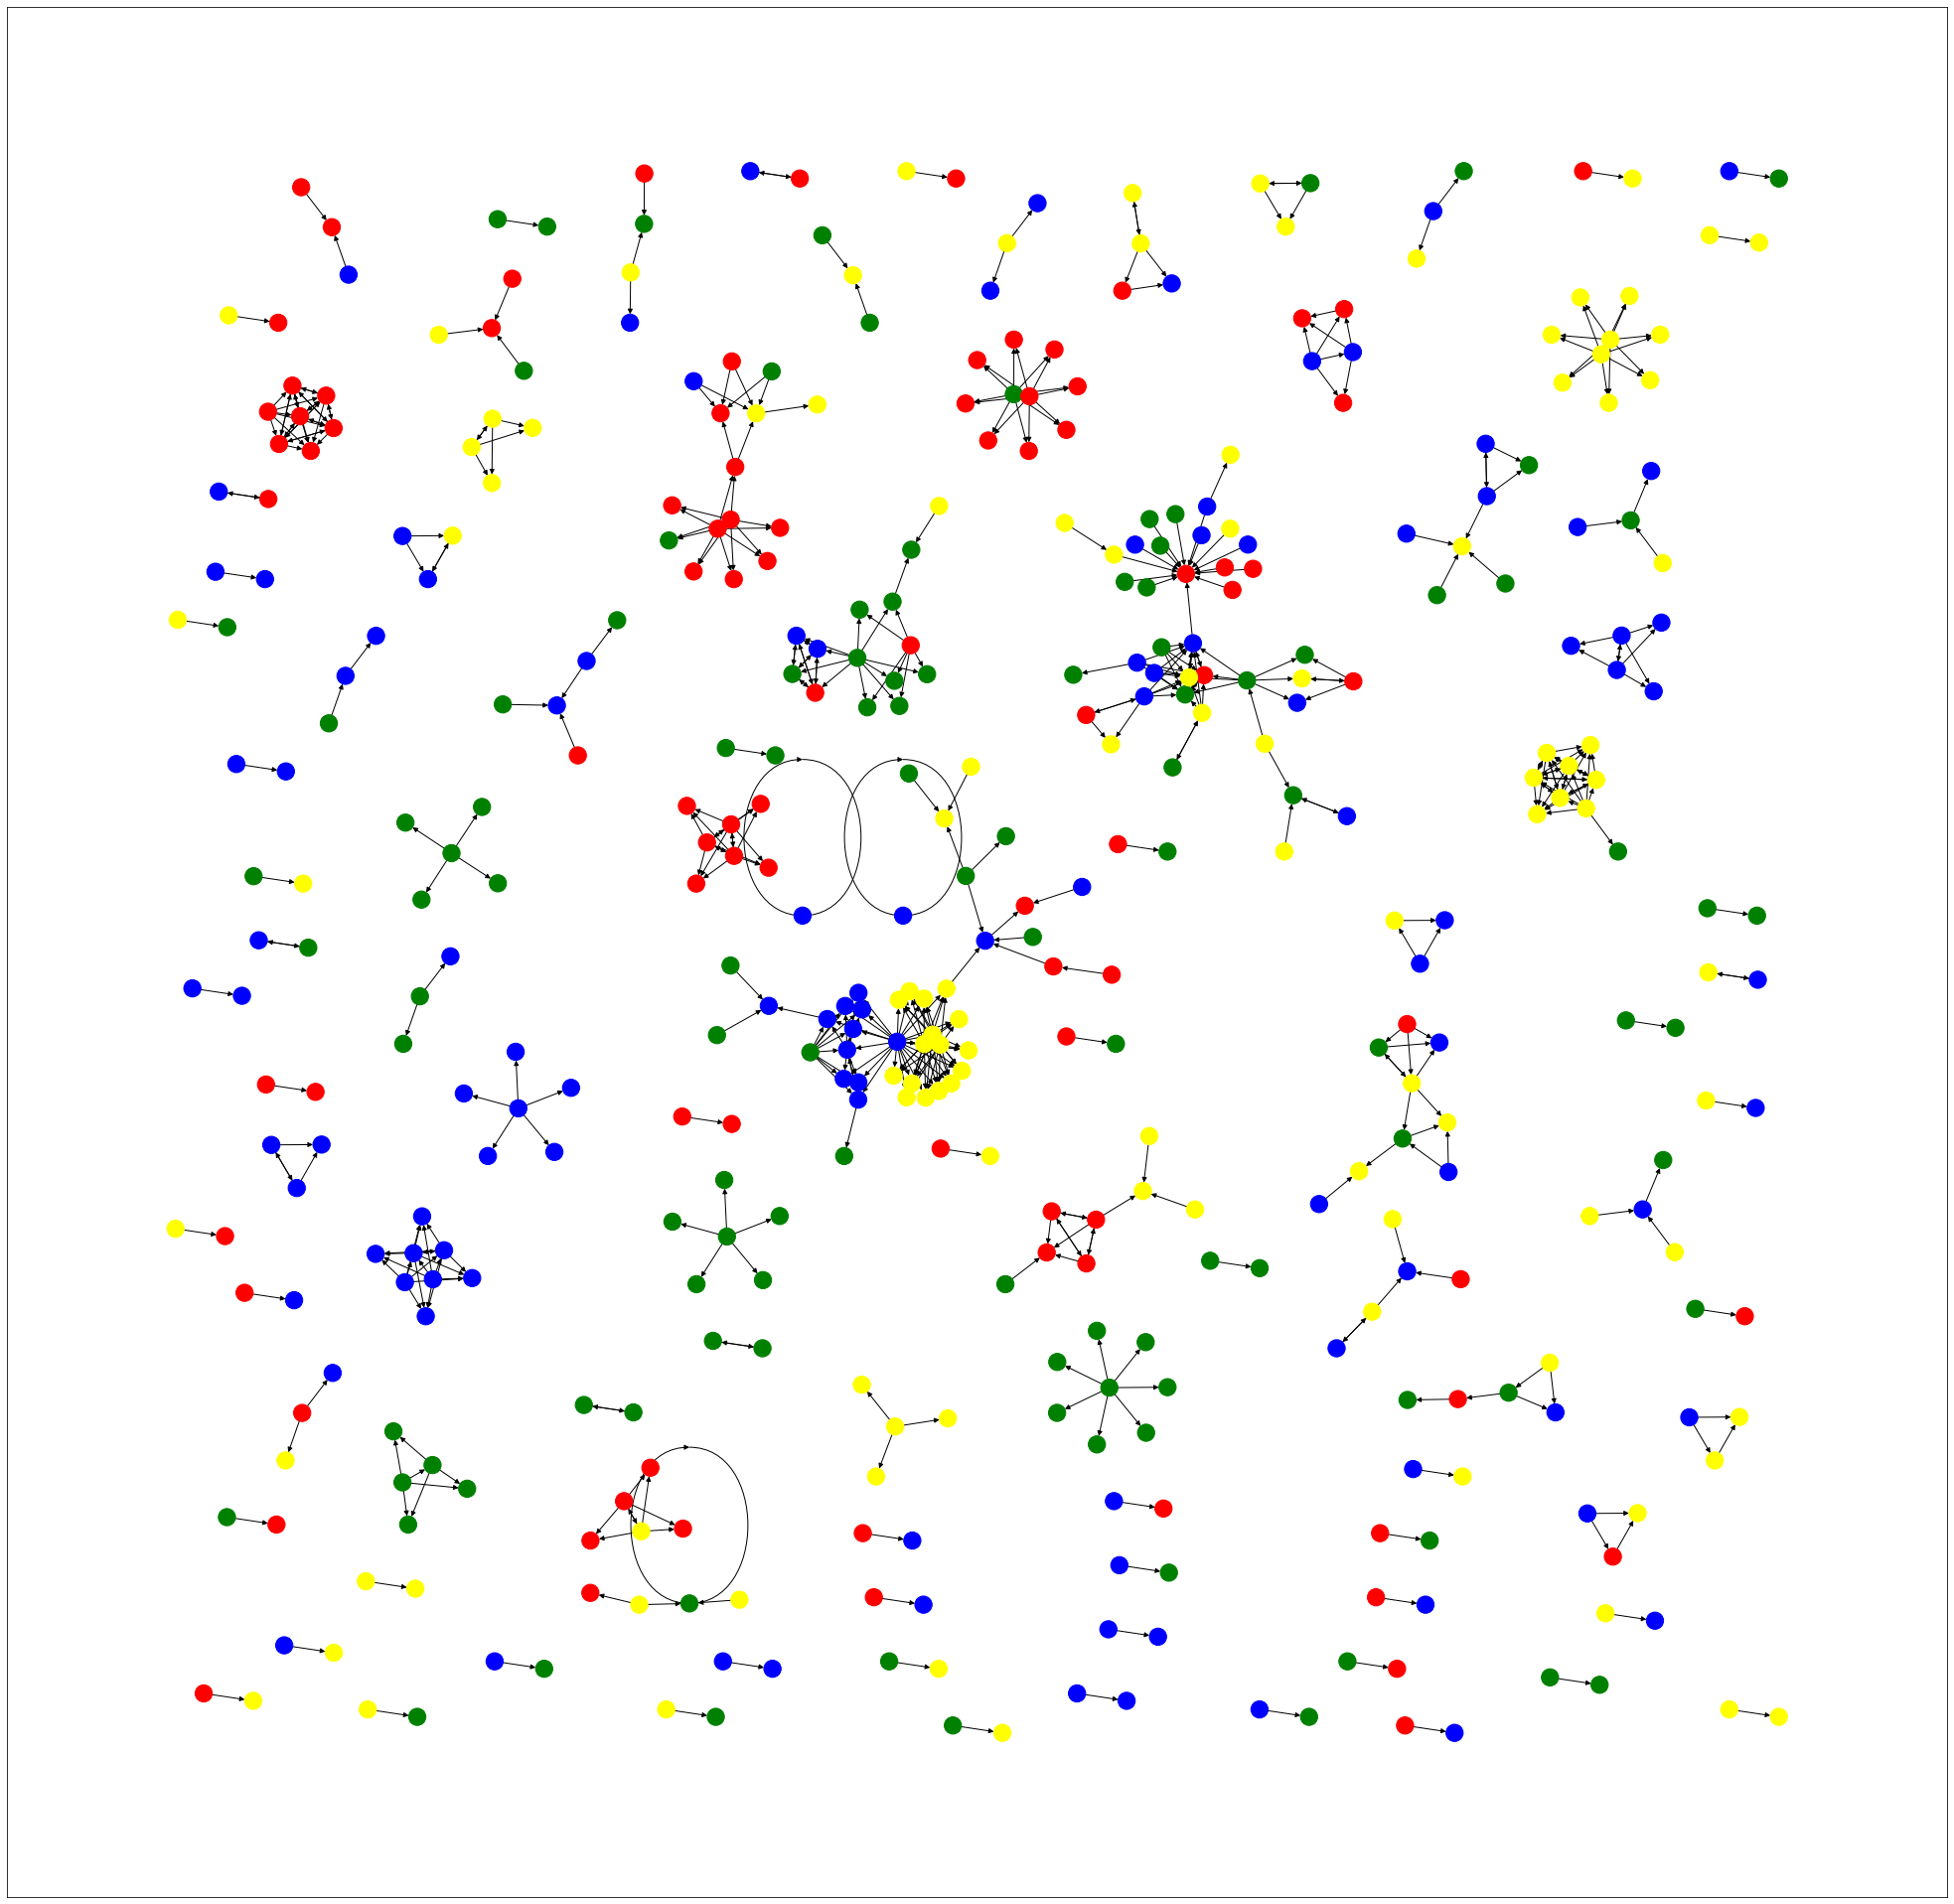

In [ ]:
g = build_graph(titulos, directores, sinopsis)
nx.write_gexf(g, "test.gexf")
plot_graph(g)

#Discusión
